## Selenium & SQLite3 

라이브러리

In [5]:
import pandas as pd
import sqlite3
from selenium import webdriver
import time
import matplotlib.pyplot as plt
from PIL import Image
import urllib.request
import glob
import os
%matplotlib inline

<br>

### SQLite 데이터베이스 준비

DB 연결

In [3]:
dbpath = "db_tour_info.db" # 있다면 해당 db 연결, 없으면 새로 생성
conn = sqlite3.connect(dbpath)
cur = conn.cursor()

테이블 생성

In [6]:
script = """ 
DROP TABLE IF EXISTS tour_crawl;

CREATE TABLE tour_crawl(
  id INTEGER PRIMARY KEY AUTOINCREMENT,  
  title TEXT,                            
  price INTEGER,                         
  image TEXT    
);
"""

cur.executescript(script) # 하나의 script로 묶은 sql 실행

script = "SELECT * FROM tour_crawl;"

df = pd.read_sql_query(script, conn) # 현재 연결된 DB에 sql 쿼리 실행하여 데이터 읽어옴
df.head()

,id,title,price,image


<br>

### selenium 활용하여 인터파크 투어 홈페이지 연결

selenium url open

In [15]:
driver = webdriver.Chrome(executable_path='(driver) chromedriver.exe') 

# 인터파크 투어 페이지 open
driver.get('http://tour.interpark.com')
time.sleep(5)

# 여행지 입력 후 검색버튼 클릭
driver.find_element_by_id('SearchGNBText').send_keys('독일')
driver.find_element_by_class_name('search-btn').click()
time.sleep(3)

# 해외여행 더보기 클릭
driver.find_element_by_class_name('moreBtn').click()
time.sleep(3)

In [8]:
maxpage = 3
## maxpage 전체 결과 수로 자동 계산
# maxpage = int(driver.find_element_by_id("totalAllCnt").text) // 10 + 1

for target_page in range(1, maxpage + 1):
    
    # 특정 자바스크립트(script)를 실행(execute)
    driver.execute_script("searchModule.SetCategoryList({}, '')".format(target_page)) 
    # 페이지 응답 기다림
    time.sleep(3)
    
    print("\n{}번째 페이지의 크롤링을 시작합니다.\n".format(target_page))
    
    # 원하는 페이지에 도착하여 전체 페이지 소스 가져와서 정리 가능 (BeautifulSoup)
#     source = driver.page_source 
#     web_page = BeautifulSoup(source, 'html.parser')
#     web_page.find_all('div', {'class': 'boxItem'})
#     ...
    
    boxItems = driver.find_elements_by_class_name('boxItem')
    # boxItems = driver.find_elements_by_css_selector('.panelZone > .oTravelBox > .boxList > li')
    
    for li in boxItems:
        title = li.find_element_by_class_name('proTit').text # li.find_element_by_css_selector('h5.proTit').text
        price = li.find_element_by_class_name('proPrice').text.replace(',','').replace('원~','') # li.find_element_by_css_selector('.proPrice')
        image = li.find_element_by_class_name('img').get_attribute('src') # 이미지 주소
        
        base_sql = "INSERT INTO tour_crawl(title, price, image) values('{}',{},'{}')" # TEXT인 제목은 ''로 감싸주는 것에 유의
        sql_query = base_sql.format(title, price, image) 
        
        print('SQL Query :', sql_query[:90], "...")
        
        cur.execute(sql_query) # 1건의 SQL Query를 실행(execute)
        conn.commit()

driver.close()
driver.quit()

print('\n크롤링이 정상적으로 종료되었습니다.')


1번째 페이지의 크롤링을 시작합니다.

SQL Query : INSERT INTO tour_crawl(title, price, image) values('[발칸/동유럽12일]장기메인NO1+베를린+할슈타트+두브로브니크_국적기 ...
SQL Query : INSERT INTO tour_crawl(title, price, image) values('[동유럽/발칸5국10일]독일 5대 이색도시+클림트KISS',25788 ...
SQL Query : INSERT INTO tour_crawl(title, price, image) values('[♥프랑스/스위스/이탈리아/오스트리아/독일 10일]',2150000  ...
SQL Query : INSERT INTO tour_crawl(title, price, image) values('[베네룩스/독일+프랑스7일]루브르박물관',2230000 ,'http: ...
SQL Query : INSERT INTO tour_crawl(title, price, image) values('[맞춤 여행]스위스/독일 자유 맞춤 견적 문의',10000 ,'htt ...
SQL Query : INSERT INTO tour_crawl(title, price, image) values('[독일7일]동화속 독일 소도시산책_OZ',1822600 ,'http: ...
SQL Query : INSERT INTO tour_crawl(title, price, image) values('[바이에른7일]독일 바이에른 자유여행 7일',1600000 ,'htt ...
SQL Query : INSERT INTO tour_crawl(title, price, image) values('[독일+체코2국8일] 중세유럽의 낭만_베를린/프라하_OZ',20900 ...
SQL Query : INSERT INTO tour_crawl(title, price, image) values('[뮌헨/드레스덴/베를린7일]독일핵심도시 자유여행',1890000 ,' ...
SQL Query : IN

In [10]:
script = "SELECT * FROM tour_crawl"

df = pd.read_sql_query(script, conn)
conn.close()

df.head()

,id,title,price,image
0,1,[발칸/동유럽12일]장기메인NO1+베를린+할슈타트+두브로브니크_국적기,2890000,http://tourimage.interpark.com/product/tour/00...
1,2,[동유럽/발칸5국10일]독일 5대 이색도시+클림트KISS,2578800,http://tourimage.interpark.com/product/tour/00...
2,3,[♥프랑스/스위스/이탈리아/오스트리아/독일 10일],2150000,http://tourimage.interpark.com/product/tour/00...
3,4,[베네룩스/독일+프랑스7일]루브르박물관,2230000,http://tourimage.interpark.com/product/tour/00...
4,5,[맞춤 여행]스위스/독일 자유 맞춤 견적 문의,10000,http://tourimage.interpark.com/product/tour/00...


<br>

### URL을 통한 이미지 다운로드

In [11]:
list(df.image.head())

['http://tourimage.interpark.com/product/tour/00161/A30/280/A3013701_16_613.jpg',
 'http://tourimage.interpark.com/product/tour/00161/A30/280/A3014270_17_983.jpg',
 'http://tourimage.interpark.com/product/tour/00161/A30/280/A3013164_2_283.jpg',
 'http://tourimage.interpark.com/product/tour/00161/A30/280/A3014977_1_123.jpg',
 'http://tourimage.interpark.com/product/tour/00161/B30/280/B3011522_1_227.jpg']

In [13]:
# images 폴더 안에 이미지 파일이 있다면 모두 삭제
previous_images = glob.glob('image/crawling/*.jpg') # 패턴을 따르는 파일들의 (경로를 포함한)파일명을 리스트로 리턴합니다.
for image in previous_images:
    os.remove(image) # 직접 파일명을 지정하여 파일을 삭제(remove)할 수 있습니다.

# 크롤링한 이미지 URL 리스트
img_urls = list(df['image'])

for index, url in enumerate(img_urls):
    # 특정 url로부터 데이터를 찾아(retrieve) 지정한 파일명으로 저장
    urllib.request.urlretrieve(url, "image/crawling/{}.jpg".format(index)) 
    print('Downloaded image # :', index)
    time.sleep(0.3)
    
print('Download completed!')

Downloaded image # : 0
Downloaded image # : 1
Downloaded image # : 2
Downloaded image # : 3
Downloaded image # : 4
Downloaded image # : 5
Downloaded image # : 6
Downloaded image # : 7
Downloaded image # : 8
Downloaded image # : 9
Downloaded image # : 10
Downloaded image # : 11
Downloaded image # : 12
Downloaded image # : 13
Downloaded image # : 14
Downloaded image # : 15
Downloaded image # : 16
Downloaded image # : 17
Downloaded image # : 18
Downloaded image # : 19
Downloaded image # : 20
Downloaded image # : 21
Downloaded image # : 22
Downloaded image # : 23
Downloaded image # : 24
Downloaded image # : 25
Downloaded image # : 26
Downloaded image # : 27
Downloaded image # : 28
Downloaded image # : 29
Download completed!


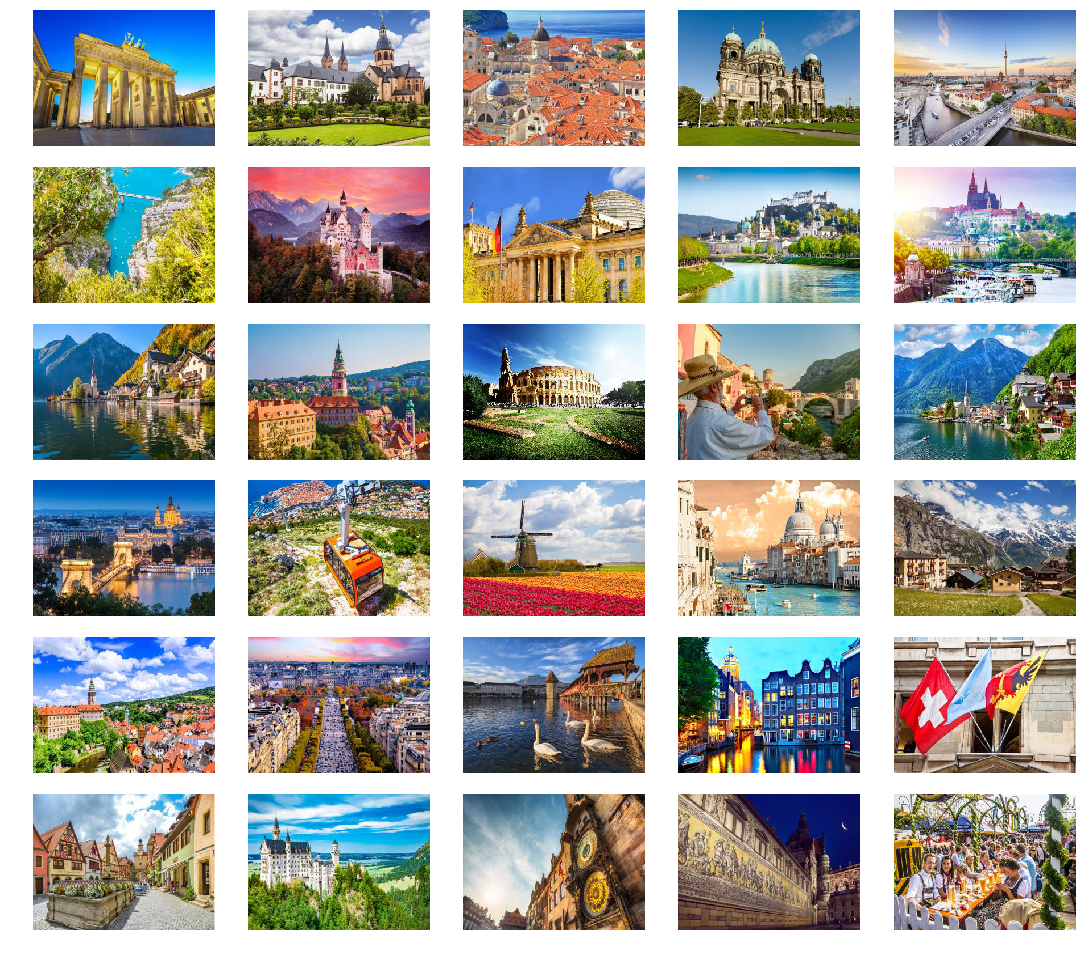

In [14]:
# subplot - 여러개의 사진 보여주기 위해 사용

fig = plt.figure(figsize=(15, 15)) 
rows = len(df['image']) // 5 + 1 # 전체 이미지를 5개씩 하나의 행에 보여줄 때 필요한 행의 수
cols = 5
i = 1
 
for filename in glob.glob("image/crawling/*.jpg"): 
    # 지정한 행(rows)과 열(cols)로 구성된 격자 내에서 i번째 plot 영역을 생성
    ax = fig.add_subplot(rows, cols, i) 
    ax.axis('off') # 불필요한 x & y축을 off
    ax.imshow(Image.open(filename))
    i += 1

plt.tight_layout(pad=0) # 불필요한 여백을 0로 세팅
plt.show()